In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

import networkx as nx
from scipy.sparse.csgraph import minimum_spanning_tree

In [2]:
def mst_graph(D: np.ndarray, stock_names: list[str]):
    mst_sparse = minimum_spanning_tree(D)
    mst_coo = mst_sparse.tocoo()

    G = nx.Graph()
    G.add_nodes_from(stock_names)

    for u, v, w in zip(mst_coo.row, mst_coo.col, mst_coo.data):
        G.add_edge(stock_names[u], stock_names[v], weight=float(w), edge_type="mst")

    return G

def mst_threshold_graph(C: np.ndarray, D: np.ndarray, stock_names: list[str], corr_threshold: float):
    G = mst_graph(D, stock_names)
    
    n = C.shape[0]
    for i in range(n):
        for j in range(i + 1, n):
            if C[i, j] >= corr_threshold and not G.has_edge(stock_names[i], stock_names[j]):
                G.add_edge(stock_names[i], stock_names[j], weight=C[i, j], edge_type="threshold")
    return G

In [3]:
df_price = pd.read_csv("data/sector_etf_prices.csv")
df_price["Date"] = pd.to_datetime(df_price["Date"], format="%Y-%m-%d")
df_price = df_price.dropna(how="any", axis=0)
df_price.head()

,Date,XLF,XLC,XLE,XLB,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
4644,2018-06-19,23.704649,46.472126,26.737791,25.089108,64.433472,33.221359,41.704494,24.398005,19.823647,74.649956,52.020676
4645,2018-06-20,23.643972,47.048851,26.855848,25.007612,64.477463,33.291138,41.745331,24.661348,19.839447,74.808281,52.267326
4646,2018-06-21,23.574638,46.760487,26.358582,24.741665,63.667965,33.035316,41.827003,24.808512,19.906597,74.377243,51.895027
4647,2018-06-22,23.461969,46.965149,26.884470,25.101980,63.887947,32.928356,42.170048,25.025383,20.044834,74.711517,51.806599
4648,2018-06-25,23.210621,45.997738,26.344273,24.711637,63.078468,32.244671,42.382412,24.963415,20.376616,74.025345,50.680374


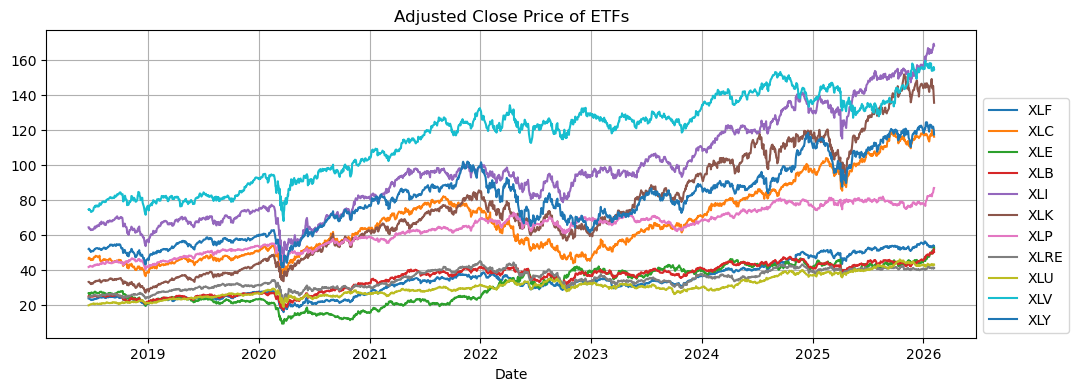

In [4]:
plt.figure(figsize=(12, 4))

for col in df_price.columns[1:]:
    plt.plot(df_price["Date"], df_price[col], label=col)

plt.title("Adjusted Close Price of ETFs")
plt.xlabel("Date")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0.8))
plt.grid()
plt.show()

In [5]:
df_logreturns = pd.DataFrame()
df_logreturns["Date"] = df_price["Date"]

for col in df_price.columns[1:]:
    df_logreturns[col] = np.log(df_price[col]) - np.log(df_price[col].shift(1))

df_logreturns = df_logreturns.dropna()
df_logreturns.head()

,Date,XLF,XLC,XLE,XLB,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
4645,2018-06-20,-0.002563,0.012334,0.004406,-0.003254,0.000683,0.002098,0.000979,0.010736,0.000797,0.002119,0.004730
4646,2018-06-21,-0.002937,-0.006148,-0.018690,-0.010692,-0.012634,-0.007714,0.001955,0.005950,0.003379,-0.005779,-0.007148
4647,2018-06-22,-0.004791,0.004367,0.019755,0.014458,0.003449,-0.003243,0.008168,0.008704,0.006920,0.004484,-0.001705
4648,2018-06-25,-0.010771,-0.020814,-0.020298,-0.015672,-0.012751,-0.020981,0.005023,-0.002479,0.016416,-0.009227,-0.021979
4649,2018-06-26,-0.003367,0.001657,0.012550,0.003812,0.003759,0.004031,-0.004249,0.005261,0.001162,-0.003094,0.007137


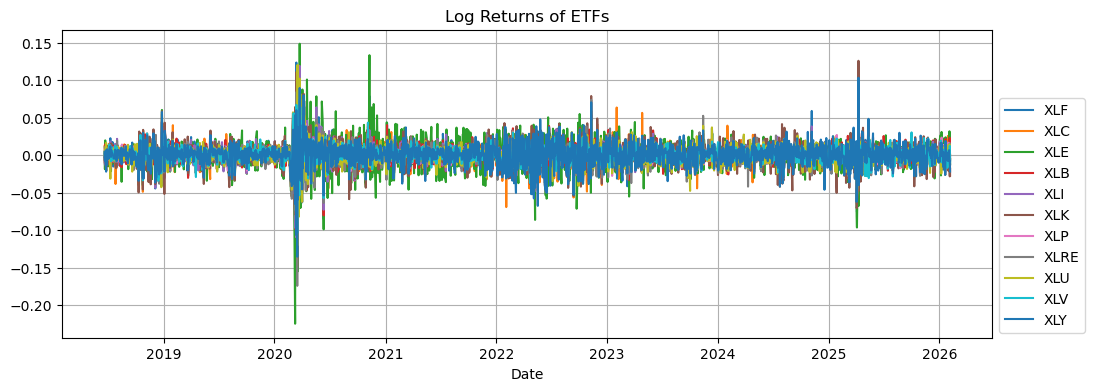

In [6]:
plt.figure(figsize=(12, 4))

for col in df_logreturns.columns[1:]:
    plt.plot(df_logreturns["Date"], df_logreturns[col], label=col)

plt.title("Log Returns of ETFs")
plt.xlabel("Date")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0.8))
plt.grid()
plt.show()

In [7]:
df_logreturns.iloc[:, 1:].describe()
for col in df_logreturns.columns[1:]:
    print(f"{col} Skewness: {df_logreturns[col].skew():.4f}")
    print(f"{col} Kurtosis: {df_logreturns[col].kurtosis():.4f}\n")

XLF Skewness: -0.5760
XLF Kurtosis: 15.4655

XLC Skewness: -0.4841
XLC Kurtosis: 7.2064

XLE Skewness: -0.9562
XLE Kurtosis: 15.2273

XLB Skewness: -0.4112
XLB Kurtosis: 9.7065

XLI Skewness: -0.5199
XLI Kurtosis: 13.3286

XLK Skewness: -0.2769
XLK Kurtosis: 8.5076

XLP Skewness: -0.4528
XLP Kurtosis: 15.6112

XLRE Skewness: -1.0485
XLRE Kurtosis: 17.6105

XLU Skewness: -0.2588
XLU Kurtosis: 15.3978

XLV Skewness: -0.4026
XLV Kurtosis: 10.3663

XLY Skewness: -0.5375
XLY Kurtosis: 7.7360



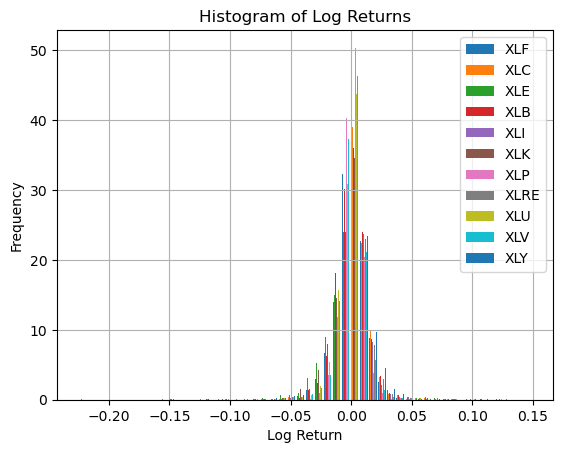

In [8]:
plt.hist(df_logreturns.iloc[:, 1:], bins=50,density=True, label=df_logreturns.columns[1:])
plt.title("Histogram of Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.grid()
plt.show()

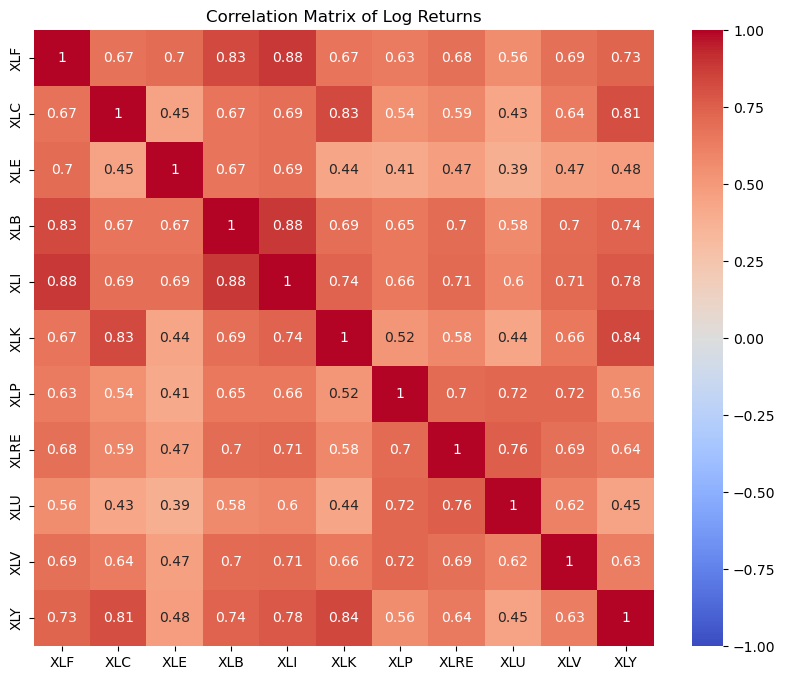

In [9]:
corrlation_matrix = df_logreturns.iloc[:, 1:].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corrlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Log Returns")
plt.show()

In [10]:
epoch_length = 40
epoch_shift = 20

stock_names = df_logreturns.columns[1:].tolist()

correlation_matrices = []
distance_matrices = []
mu_values = []
epoch_dates = []

for i in range(0, len(df_logreturns) - epoch_length, epoch_shift):
  epoch = df_logreturns.iloc[i:i+epoch_length]

  correlation_matrix = epoch.iloc[:, 1:].corr().values
  distance_matrix = np.sqrt(2 * (1 - correlation_matrix))
  mu = np.mean(correlation_matrix)

  correlation_matrices.append(correlation_matrix)
  distance_matrices.append(distance_matrix)
  mu_values.append(mu)

  epoch_dates.append(epoch["Date"].iloc[-1])

print(len(correlation_matrices))

94


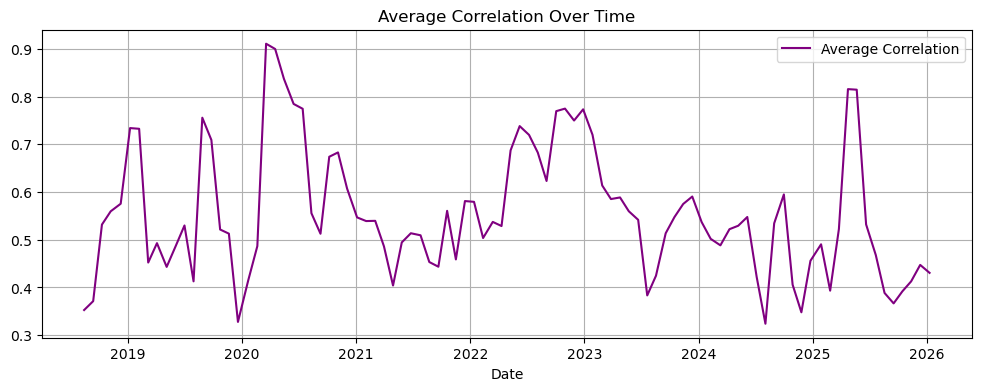

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(epoch_dates, mu_values, color="purple", label="Average Correlation")
plt.title("Average Correlation Over Time")
plt.xlabel("Date")
plt.grid()
plt.legend()
plt.show()

In [12]:
graphs = []
for C, D in zip(correlation_matrices, distance_matrices):
    G = mst_threshold_graph(C, D, stock_names=stock_names, corr_threshold=0.75)
    graphs.append(G)

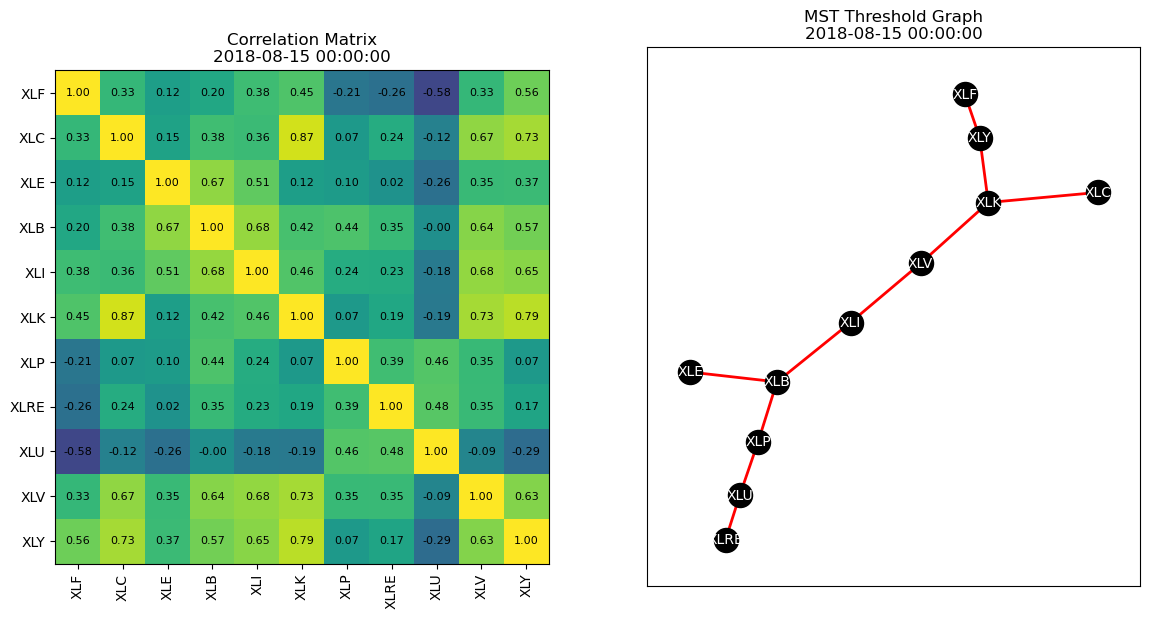

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

def update(frame):
    axes[0].clear()
    axes[1].clear()

    C = correlation_matrices[frame]
    im = axes[0].imshow(C, vmin=-1, vmax=1)

    axes[0].set_title(f"Correlation Matrix\n{epoch_dates[frame]}")
    axes[0].set_xticks(range(n_assets))
    axes[0].set_yticks(range(n_assets))
    axes[0].set_xticklabels(tickers, rotation=90)
    axes[0].set_yticklabels(tickers)
    for i in range(n_assets):
        for j in range(n_assets):
            val = C[i, j]
            axes[0].text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color="black")
    axes[0].set_aspect("equal")

    G = graphs[frame]
    pos = nx.spring_layout(G, seed=42)

    mst_edges = [(u, v) for u, v, d in G.edges(data=True) if d["edge_type"] == "mst"]

    nx.draw_networkx_nodes(G, pos, ax=axes[1], node_size=300, node_color="black")
    nx.draw_networkx_edges(G, pos, ax=axes[1], edgelist=mst_edges, width=2, edge_color="red")
    nx.draw_networkx_labels(G, pos, ax=axes[1], font_size=10, font_color="white")

    axes[1].set_title(f"MST Threshold Graph\n{epoch_dates[frame]}")
    
    return axes
    

tickers = df_logreturns.columns[1:]
n_assets = len(tickers)
ani = animation.FuncAnimation(fig, update, frames=len(correlation_matrices), interval=500, repeat=False)
ani.save("Correlation_Dynamics_2018.gif",writer="pillow",dpi=150)